In [171]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [172]:
# Database already separated, so kind
train_df = pd.read_csv("../../dataset/rnn/train.csv")
val_df = pd.read_csv("../../dataset/rnn/valid.csv")
test_df = pd.read_csv("../../dataset/rnn/test.csv")

In [173]:
label_mapping = {"negative": 0,
                 "neutral": 1,
                 "positive": 2
                 }

# Take text and label only
train_df = train_df[["text", "label"]]
val_df = val_df[["text", "label"]]
test_df = test_df[["text", "label"]]

# Warning!!! Not idempotent operations :(
train_df["label"] = train_df["label"].map(label_mapping)
val_df["label"] = val_df["label"].map(label_mapping)
test_df["label"] = test_df["label"].map(label_mapping)

In [174]:
train_texts = train_df["text"].tolist()
train_labels = train_df["label"].tolist()

val_texts = val_df["text"].tolist()
val_labels = val_df["label"].tolist()

test_texts = test_df["text"].tolist()
test_labels = test_df["label"].tolist()

In [175]:
vectorizer = keras.layers.TextVectorization(
    output_mode='int'
)
vectorizer.adapt(train_texts)

In [176]:
x_train = vectorizer(np.array(train_texts))
x_val = vectorizer(np.array(val_texts))
x_test = vectorizer(np.array(test_texts))

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

In [177]:
embedder = keras.layers.Embedding(
    input_dim=len(vectorizer.get_vocabulary()), 
    output_dim=100
)

In [178]:
x_train_embed = embedder(x_train) 
x_val_embed = embedder(x_val) 
x_test_embed = embedder(x_test) 

In [179]:
from sklearn.metrics import f1_score
from keras.callbacks import Callback
import numpy as np

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val)
        
        # Check if multi-class
        if y_pred.ndim > 1 and y_pred.shape[1] > 1:
            y_pred_labels = np.argmax(y_pred, axis=1)
        else:
            y_pred_labels = (y_pred > 0.5).astype(int).flatten()

        y_true_labels = self.y_val if len(self.y_val.shape) == 1 else np.argmax(self.y_val, axis=1)
        
        f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
        print(f'Epoch {epoch + 1} - F1 Score: {f1:.4f}\n')

f1_callback = F1ScoreCallback(x_val_embed, y_val)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/stepep - accuracy: 0.3529 - loss:
Epoch 1 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 575ms/step - accuracy: 0.3544 - loss: 1.0998 - val_accuracy: 0.3800 - val_loss: 1.0806
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/stepep - accuracy: 0.4042 - loss: 
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 415ms/step - accuracy: 0.4025 - loss: 1.0838 - val_accuracy: 0.3800 - val_loss: 1.0811
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step ep - accuracy: 0.3732 - loss: 
Epoch 3 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - accuracy: 0.3735 - loss: 1.0793 - val_accuracy: 0.3800 - val_loss: 1.0793
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/stepep - accuracy: 0.3526 - loss: 
Epoch 4 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 411ms/step - accuracy: 0.3516 - loss: 1.0746 - val_accuracy: 0.3800 - val_loss: 1.0793
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step ep - accuracy: 0.4090 - loss: 
Epoch 5 - F1 Score: 

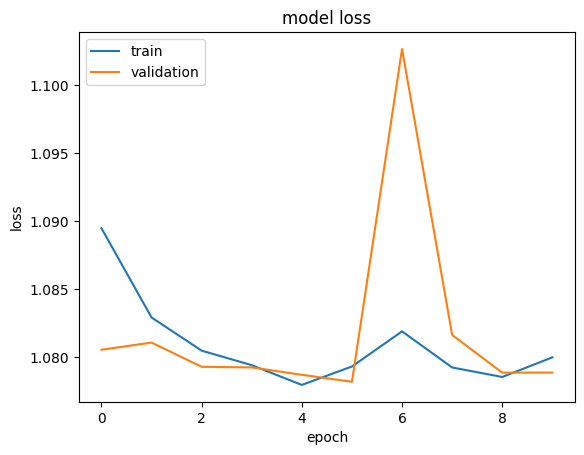

In [180]:
model1 = keras.models.Sequential([
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256),
    
    keras.layers.Dense(3, activation="softmax")
])

model1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history1 = model1.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model1.save_weights("model1.weights.h5")

# Grafik Loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/stepep - accuracy: 0.3714 - loss:
Epoch 1 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 937ms/step - accuracy: 0.3722 - loss: 1.0975 - val_accuracy: 0.3800 - val_loss: 1.0866
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/stepep - accuracy: 0.3452 - loss
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 678ms/step - accuracy: 0.3469 - loss: 1.1133 - val_accuracy: 0.3800 - val_loss: 1.0804
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/stepep - accuracy: 0.4168 - loss
Epoch 3 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 682ms/step - accuracy: 0.4154 - loss: 1.0846 - val_accuracy: 0.3800 - val_loss: 1.0817
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/stepep - accuracy: 0.3960 - loss
Epoch 4 - F1 Score: 0.2012

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 702ms/step - accuracy: 0.3952 - loss: 1.0785 - val_accuracy: 0.3600 - val_loss: 1.0801
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/stepep - accuracy: 0.4232 - loss:
Epoch 5 - F1 Score: 0.20

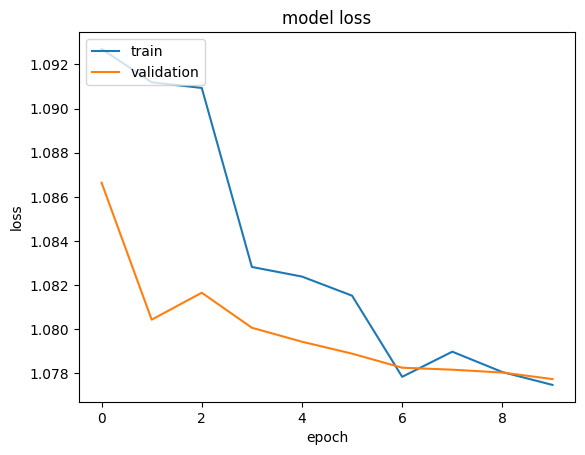

In [181]:
model2 = keras.models.Sequential([
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256),
    
    keras.layers.Dense(3, activation="softmax")
])

model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history2 = model2.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model2.save_weights("model2.weights.h5")

# Grafik Loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/stepep - accuracy: 0.4114 - loss:
Epoch 1 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4092 - loss: 1.0980 - val_accuracy: 0.3800 - val_loss: 1.0825
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/stepep - accuracy: 0.3855 - loss
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 856ms/step - accuracy: 0.3854 - loss: 1.0889 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/stepep - accuracy: 0.3732 - loss
Epoch 3 - F1 Score: 0.4344

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 815ms/step - accuracy: 0.3727 - loss: 1.0757 - val_accuracy: 0.5000 - val_loss: 1.0784
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/stepep - accuracy: 0.3535 - loss
Epoch 4 - F1 Score: 0.4276

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 813ms/step - accuracy: 0.3540 - loss: 1.0890 - val_accuracy: 0.4900 - val_loss: 1.0770
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/stepep - accuracy: 0.4170 - loss
Epoch 5 - F1 Score: 0.2093



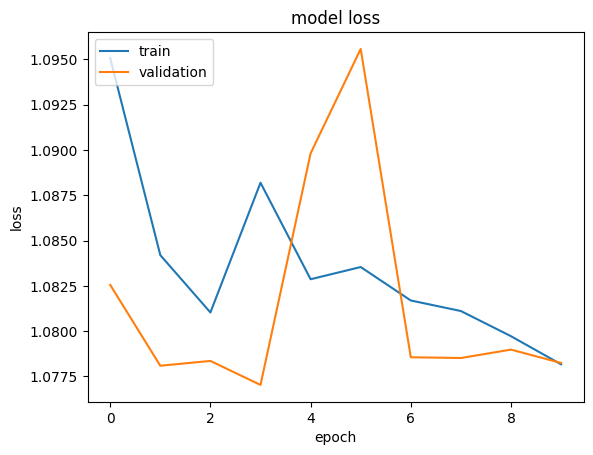

In [182]:
model3 = keras.models.Sequential([
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256),
    
    keras.layers.Dense(3, activation="softmax")
])

model3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history3 = model3.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model3.save_weights("model3.weights.h5")

# Grafik Loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/stepep - accuracy: 0.3748 - loss
Epoch 1 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3755 - loss: 1.0941 - val_accuracy: 0.3800 - val_loss: 1.0822
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/stepep - accuracy: 0.3923 - loss
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 964ms/step - accuracy: 0.3918 - loss: 1.0820 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/stepep - accuracy: 0.3510 - loss
Epoch 3 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 880ms/step - accuracy: 0.3515 - loss: 1.0860 - val_accuracy: 0.3800 - val_loss: 1.0805
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/stepep - accuracy: 0.3605 - loss
Epoch 4 - F1 Score: 0.4169

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 919ms/step - accuracy: 0.3599 - loss: 1.0773 - val_accuracy: 0.4100 - val_loss: 1.0441
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/stepep - accuracy: 0.4383 - loss
Epoch 5 - F1 Score: 0.4307

1

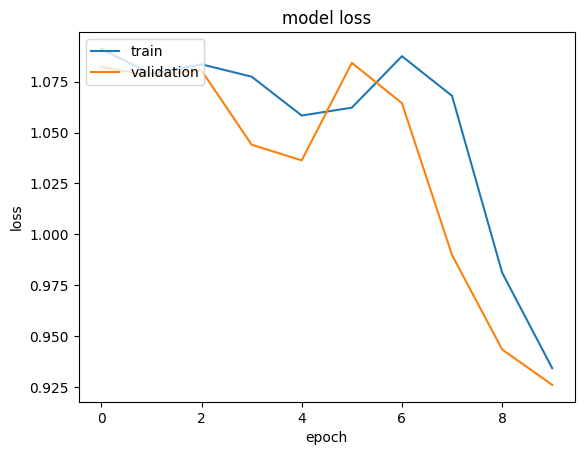

In [183]:
model4 = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(512, return_sequences=True),
    keras.layers.LSTM(256),
    
    keras.layers.Dense(3, activation="softmax")
])

model4.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history4 = model4.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model4.save_weights("model4.weights.h5")

# Grafik Loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/stepep - accuracy: 0.3464 - loss: 
Epoch 1 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 668ms/step - accuracy: 0.3480 - loss: 1.0994 - val_accuracy: 0.3800 - val_loss: 1.0802
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/steptep - accuracy: 0.3906 - loss: 1.
Epoch 2 - F1 Score: 0.2425

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 429ms/step - accuracy: 0.3902 - loss: 1.0755 - val_accuracy: 0.3600 - val_loss: 1.0782
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step ep - accuracy: 0.4197 - loss: 1.
Epoch 3 - F1 Score: 0.3268

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 365ms/step - accuracy: 0.4196 - loss: 1.0721 - val_accuracy: 0.4100 - val_loss: 1.0603
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step ep - accuracy: 0.4170 - loss: 1.
Epoch 4 - F1 Score: 0.3918

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 419ms/step - accuracy: 0.4190 - loss: 1.0645 - val_accuracy: 0.4600 - val_loss: 1.0147
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/stepep - accuracy: 0.4647 - loss
Epoch 5 - F1 Sc

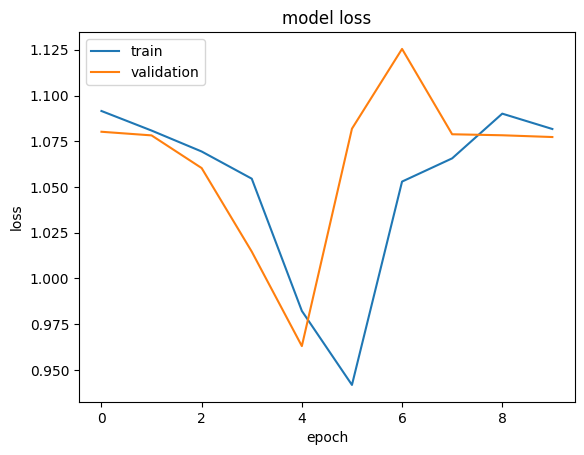

In [184]:
model5 = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32),
    
    keras.layers.Dense(3, activation="softmax")
])

model5.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history5 = model5.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model5.save_weights("model5.weights.h5")

# Grafik Loss
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/stepep - accuracy: 0.3548 - loss
Epoch 1 - F1 Score: 0.3244

16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 884ms/step - accuracy: 0.3551 - loss: 1.0913 - val_accuracy: 0.4200 - val_loss: 1.0869
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/stepep - accuracy: 0.4001 - loss
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 616ms/step - accuracy: 0.3989 - loss: 1.0870 - val_accuracy: 0.3800 - val_loss: 1.0802
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/stepep - accuracy: 0.3719 - loss:
Epoch 3 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 585ms/step - accuracy: 0.3723 - loss: 1.0882 - val_accuracy: 0.3800 - val_loss: 1.0825
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/stepep - accuracy: 0.3971 - loss
Epoch 4 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 576ms/step - accuracy: 0.3958 - loss: 1.0793 - val_accuracy: 0.3800 - val_loss: 1.0789
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/stepep - accuracy: 0.4092 - loss
Epoch 5 - F1 Score: 0.2093


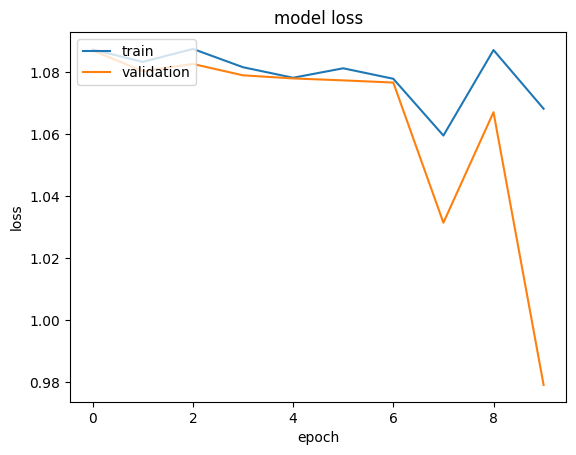

In [185]:
model6 = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(512),
    
    keras.layers.Dense(3, activation="softmax")
])

model6.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history6 = model6.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model6.save_weights("model6.weights.h5")

# Grafik Loss
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/stepep - accuracy: 0.3703 - loss: 1
Epoch 1 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 464ms/step - accuracy: 0.3714 - loss: 1.0873 - val_accuracy: 0.3800 - val_loss: 1.0823
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/steptep - accuracy: 0.3822 - loss: 1.0
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.3823 - loss: 1.0807 - val_accuracy: 0.3800 - val_loss: 1.0814
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step ep - accuracy: 0.3747 - loss: 1.
Epoch 3 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 365ms/step - accuracy: 0.3747 - loss: 1.0778 - val_accuracy: 0.3800 - val_loss: 1.0798
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/stepep - accuracy: 0.3673 - loss: 1
Epoch 4 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.3674 - loss: 1.0736 - val_accuracy: 0.3800 - val_loss: 1.0797
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/steptep - accuracy: 0.3990 - loss: 1.0
Epoch 5 -

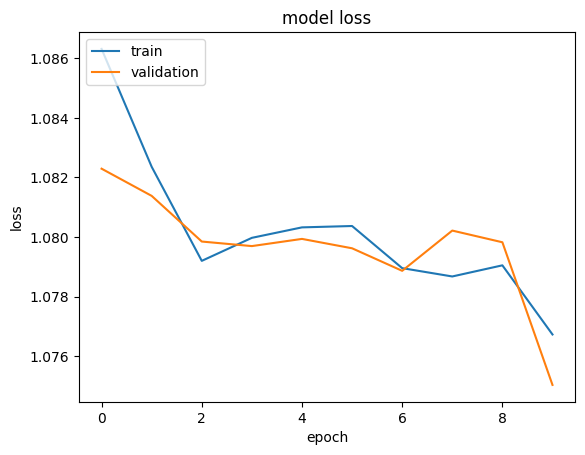

In [186]:
model7 = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(64),
    
    keras.layers.Dense(3, activation="softmax")
])

model7.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history7 = model7.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model7.save_weights("model7.weights.h5")

# Grafik Loss
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model8 = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(64),
    
    keras.layers.Dense(3, activation="softmax")
])

model8.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history8 = model8.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model8.save_weights("model8.weights.h5")

# Grafik Loss
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()